# Huggingface 모델 사용하기
- Depth estimation 


In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [1]:
# 라이브러리 임포트

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
# path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window 
font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [42]:
# 파이토치 관련 라이브러리

import torch
from torch import nn, optim
from torchinfo import summary
from torchviz import make_dot
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import cv2

In [ ]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = ":"

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [ ]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

## 라이브러리 설치

In [107]:
!pip install -q transformers

## Depth estimation

- https://huggingface.co/docs/transformers/v4.32.0/ko/tasks/monocular_depth_estimation

### 영상 읽기

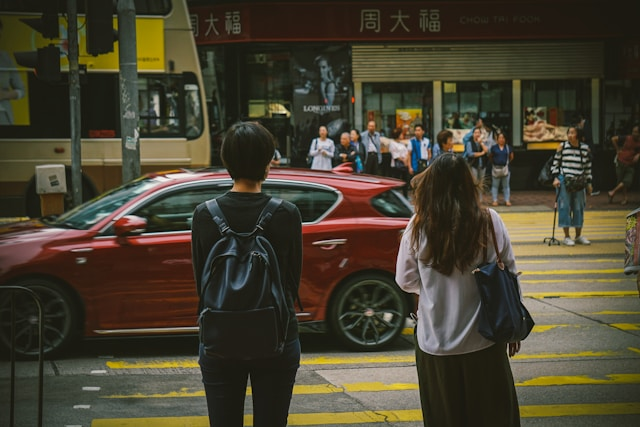

In [72]:
from PIL import Image
import requests

image = Image.open("./figure/cross_road.jpg")
image

## from url
# url = "https://pds.joongang.co.kr/news/component/htmlphoto_mmdata/202205/21/1200738c-61c0-4a51-83c4-331f53d4dcdc.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

### 모델과 관련 프로세서

In [50]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

## hugging face model
checkpoint = "vinvino02/glpn-nyu" 

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint)

In [80]:
## 영상 전처리

# image = np.array(image)
pixel_values = image_processor(image, return_tensors="pt").pixel_values
pixel_values.shape
image.size[::-1]

(427, 640)

### 모델 추론

In [74]:
import torch

with torch.no_grad():
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth

In [82]:
print('output shape = ', predicted_depth.shape)
print('output dtype = ', predicted_depth.dtype)

output shape =  torch.Size([1, 416, 640])
output dtype =  torch.float32


In [83]:
import numpy as np

# 원본 사이즈로 복원
# 작은 사이즈의 이미지를 큰 사이즈로 키울 때
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
).squeeze()
output = prediction.numpy()
print('output shape = ', output.shape)
print(type(output))

output shape =  (427, 640)
<class 'numpy.ndarray'>


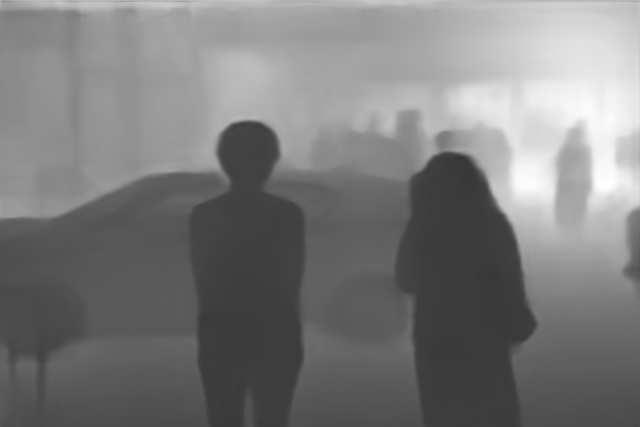

In [95]:
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth


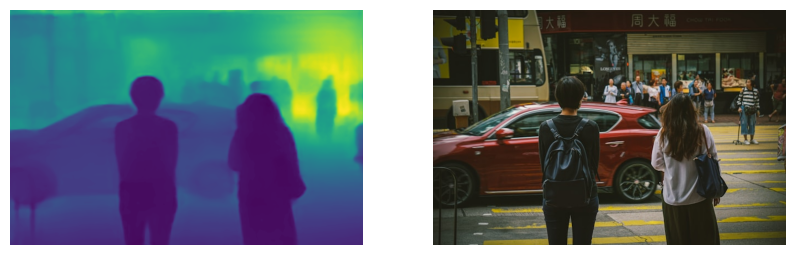

In [96]:
plt.figure(figsize = (10, 5))
plt.subplot(121), plt.imshow(formatted), plt.axis("off")
plt.subplot(122), plt.imshow(image), plt.axis("off")

plt.show()

### Depth estimation 파이프라인

In [90]:
from transformers import pipeline

checkpoint = "vinvino02/glpn-nyu"
depth_estimator = pipeline("depth-estimation", model=checkpoint)


Device set to use cuda:0


In [91]:
predictions = depth_estimator(image)
predictions

{'predicted_depth': tensor([[4.7797, 4.5470, 4.4099,  ..., 5.0188, 4.9786, 5.0841],
         [4.5749, 4.1531, 3.8833,  ..., 4.6949, 4.7889, 5.0931],
         [4.8394, 4.5267, 4.3063,  ..., 5.2161, 5.2414, 5.4234],
         ...,
         [2.2125, 2.1903, 2.1941,  ..., 2.0539, 2.0784, 2.0870],
         [2.2620, 2.1589, 2.2172,  ..., 2.0517, 2.1296, 2.0617],
         [2.3546, 2.2836, 2.1795,  ..., 2.0370, 2.0472, 2.1612]]),
 'depth': <PIL.Image.Image image mode=L size=640x427>}

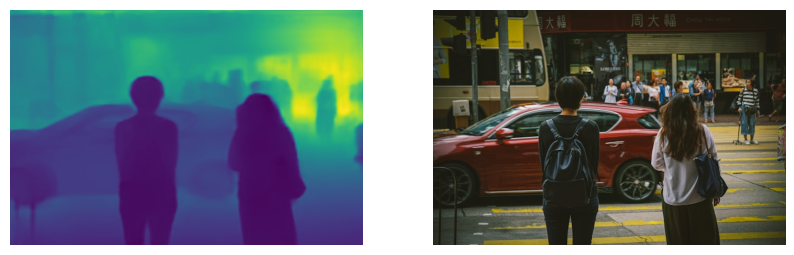

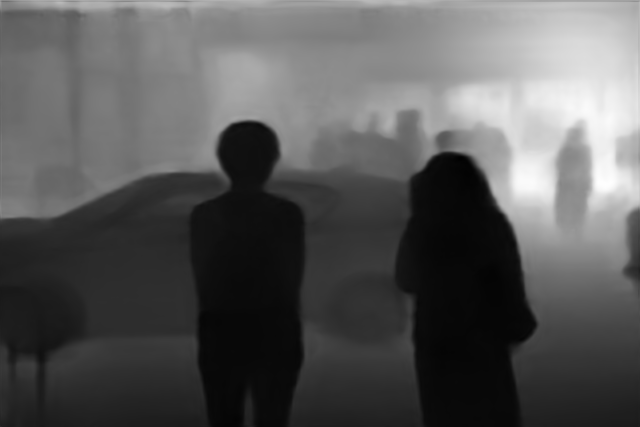

In [98]:
plt.figure(figsize = (10, 5))
plt.subplot(121), plt.imshow(predictions["depth"]), plt.axis("off")
plt.subplot(122), plt.imshow(image), plt.axis("off")

plt.show()
predictions["depth"]

## Image to text

In [143]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))
# >>> a photography of a woman and her dog

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))
# >>> a woman sitting on the beach with her dog


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

a photography of a woman and her dog on the beach
a woman sitting on the beach with her dog
